# Dust coma brightness

sbpy has two classes that can be used to estimate coma brightness: `Afrho` and `Efrho`.  These are based on the *Afρ* and *εfρ* quantities of A'Hearn et al. (1984) and Kelley et al. (2013).  In this excercise, we will

  * Convert photometry to the *Afρ* quantity,
  * Generate an *Afρ*-based lightcurve of a comet, and
  * Plot the scattered sunlight and thermal emission spectrum of a comet.

## Background

Given a circular aperture of radius *ρ* centered on the comet, *Afρ* is the product of albedo, filling factor, and aperture radius in units of length projected to the distance of the comet.  *εfρ* is the thermal emission counterpart, and exchanges emissivity for albedo.  Both quantities are in units of length.  Under certain assumptions, they are proportional to the dust mass loss rate of the nucleus (Fink and Rubin 2012).

## *Afρ* for C/2017 K2 (PanSTARRS)

Calculate *Afρ* with photometry of comet C/2017 K2 (PanSTARRS) from Meech et al. (2017).

### Top-level imports and bibliography tracking

In [1]:
import numpy as np

import astropy.units as u
from astropy.time import Time

from sbpy.activity import Afrho
from sbpy.calib import Sun
from sbpy import bib

bib.track()

### Observation circumstances and photometry

In [2]:
eph = {
    'date': Time(['2014-03-20', '2016-05-27', '2017-09-15']),
    'rh': [22.22, 18.09, 15.42] * u.au,
    'delta': [22.20, 18.05, 15.48] * u.au,
    'phase': [2.57, 3.21, 3.72] * u.deg
}
bandpass = 'SDSS r'
aper = 5 * u.arcsec
fluxd = [20.67, 19.53, 18.87] * u.ABmag
err = [0.30, 0.04, 0.01] * u.mag  # unitless magnitudes

All three data points calibrated to the SDSS *r'*-band filter.  The flux density of the Sun through this filter is built-in to sbpy, based on calculations by Willmer (2018):

In [3]:
sun = Sun.from_default()
print(sun.observe(bandpass))

167.49428760264365 erg / (Angstrom cm2 s)


### Convert flux density to *Afρ*

Pass all parameters to `Afrho.from_fluxd()`.  Enable the correction to phase angle 0° with the `phasecor` keyword argument.

In [4]:
afrho = Afrho.from_fluxd(bandpass, fluxd, aper, eph, phasecor=True)
afrho_err = afrho * err.value / 1.0857
for i in range(3):
    print('{:.1f} ± {:.1f}'.format(afrho[i], afrho_err[i]))

2760.2 cm ± 762.7 cm
4359.0 cm ± 160.6 cm
5088.2 cm ± 46.9 cm


## Predict brightness at perihelion

Estimate the growth of activity and extrapolate to 1.8 au.

### Additional imports

For this excercise, we will get the ephemeris of the comet from the Minor Planet Center and will make a plot.

In [5]:
import matplotlib.pyplot as plt
from sbpy.data import Ephem

### Fit and extrapolate

Fit the data as a line in logarithmic space.

In [6]:
x = np.log(eph['rh'].value)
y = np.log(afrho.value)
fit = np.polyfit(x, y, 1)
print(fit)

[-1.6998942  13.22708478]


Get the ephemeris through perihelion and estimate *Afρ*.  Convert to flux density using the same bandpass and aperture as before.  Apply the phase correction to convert from 0° phase to the phase angle of each epoch with the `phasecor` keyword argument.

In [7]:
epochs ={
    'start': Time('2014-03-20'),
    'stop': Time('2024-03-20'),
    'step': 30 * u.day
}
eph_e = Ephem.from_mpc('C/2017 K2', epochs=epochs)

afrho_e = Afrho((eph_e['rh'] / u.au)**fit[0] * np.exp(fit[1]) * afrho.unit)
fluxd_e = afrho_e.to_fluxd(bandpass, aper, eph_e, unit=u.ABmag, phasecor=True)

In [8]:
print(afrho_e.max(), fluxd_e.max())

203453.8040164624 cm 20.637255887883924 mag(AB)


### Plot lightcurve

<IPython.core.display.Javascript object>


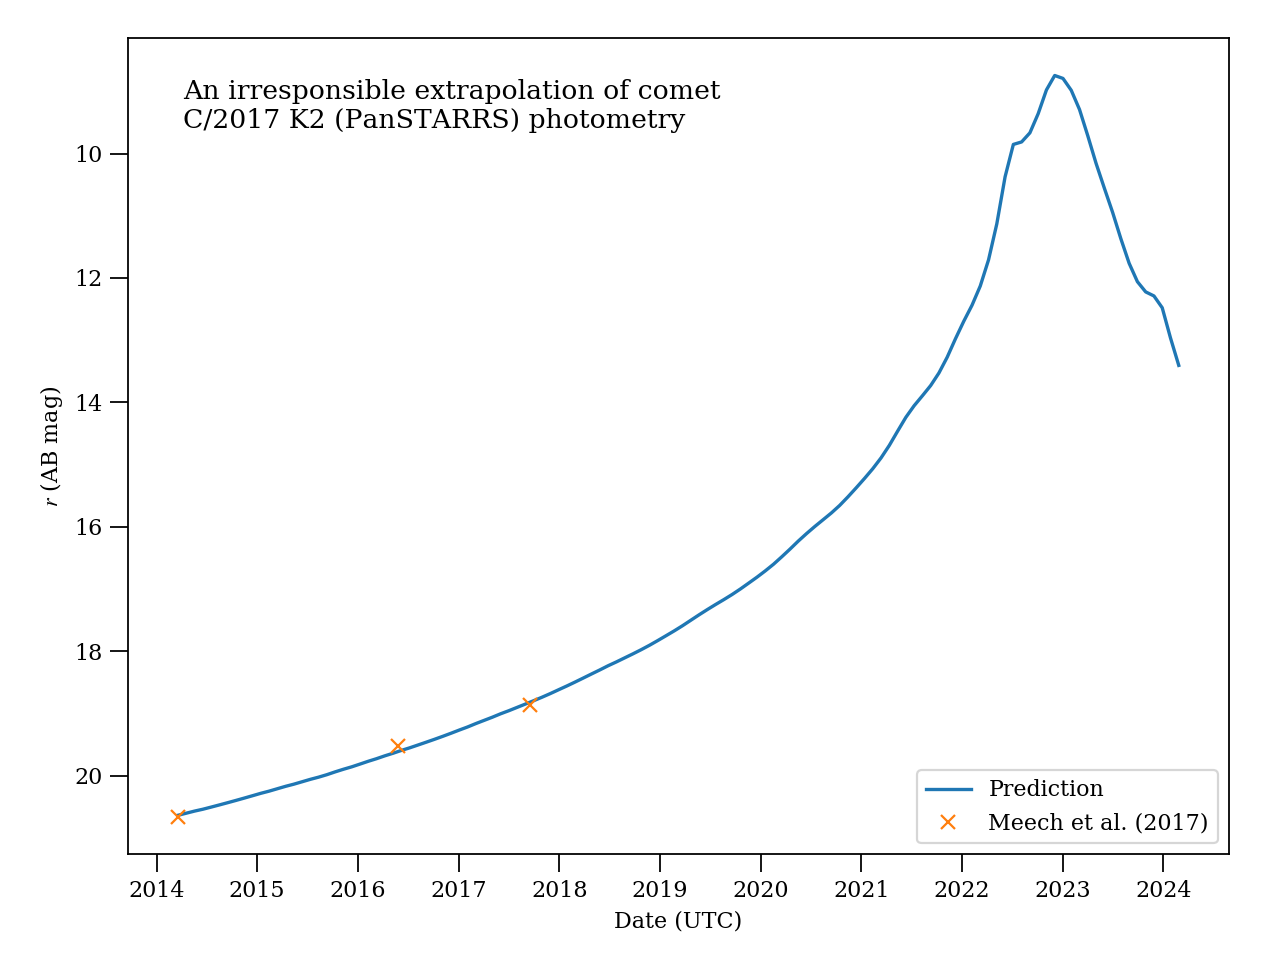

In [9]:
%matplotlib notebook
plt.figure(1, (8, 6))
ax = plt.gca()
ax.plot_date(eph_e['date'].plot_date, fluxd_e, ls='-', marker=None,
            label='Prediction')
ax.plot_date(eph['date'].plot_date, fluxd, marker='x',
            label='Meech et al. (2017)')
ax.invert_yaxis()
plt.setp(ax, ylabel='$r$ (AB mag)', xlabel='Date (UTC)')
plt.text(0.05, 0.95, '''An irresponsible extrapolation of comet
C/2017 K2 (PanSTARRS) photometry''', fontsize=12, transform=ax.transAxes, va='top')
plt.legend(loc='lower right')
plt.show()

## Plot the spectrum at perihelion

Use `Afrho` and `Efrho` together to estimate the spectrum near perihelion.  Assume *εfρ/Αfρ* = 3.5 (cf. Kelley et al. 2016).

<IPython.core.display.Javascript object>


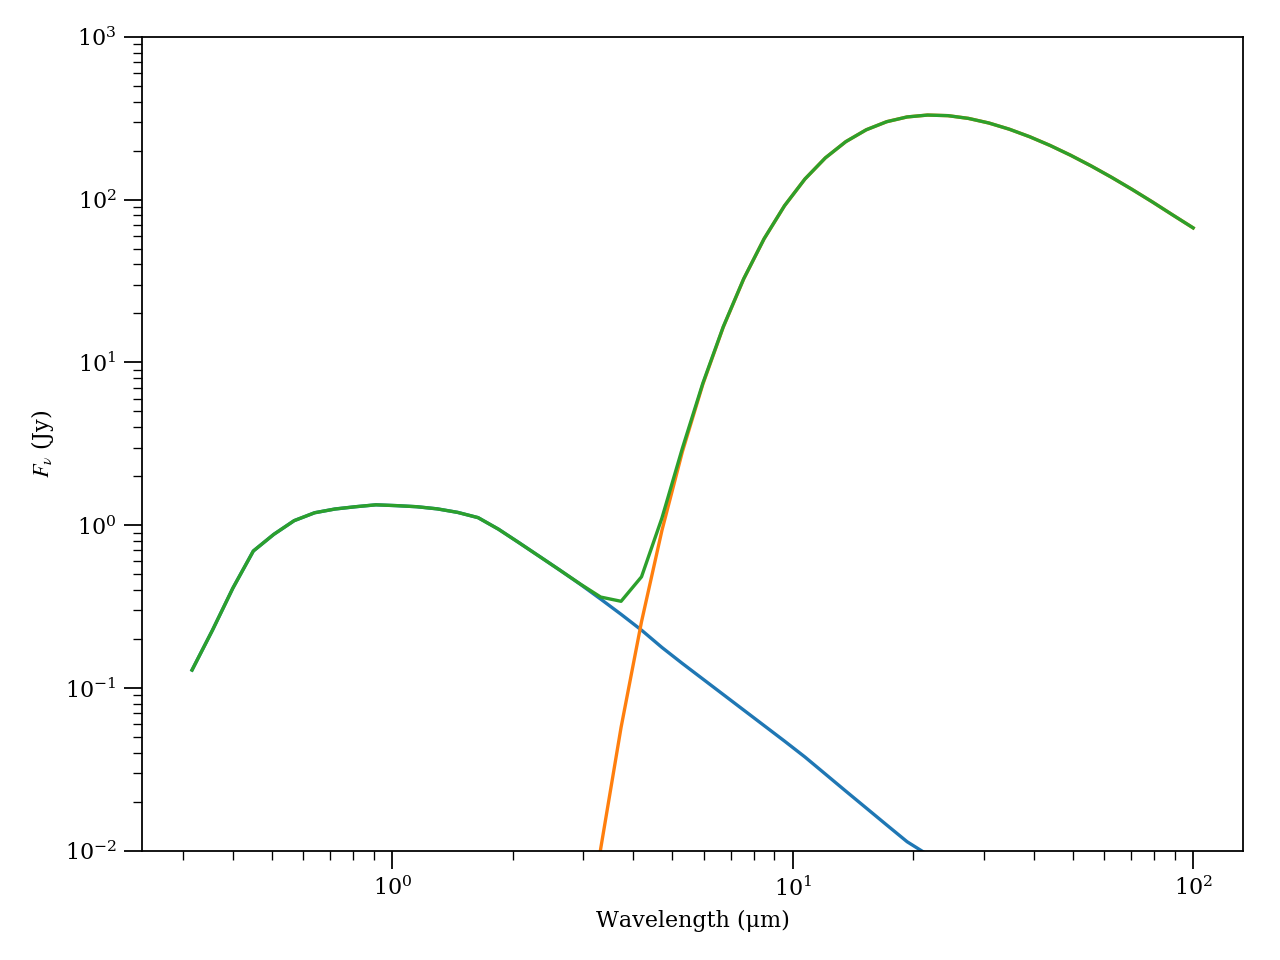

In [10]:
from sbpy.activity import Efrho

Tp = Time('2022-12-21')
eph_s = Ephem.from_mpc('C/2017 K2', epochs=Tp)

afrho_s = Afrho((eph_s['rh'] / u.au)**fit[0] * np.exp(fit[1]) * afrho.unit)
efrho_s = Efrho(3.5 * afrho_s)

wave = np.logspace(-0.5, 2) * u.um
fsca = afrho_s.to_fluxd(wave, aper, eph_s, unit=u.Jy, phasecor=True)
fthrm = efrho_s.to_fluxd(wave, aper, eph_s, unit=u.Jy)

plt.figure(2, (8, 6))
ax = plt.gca()
for f in (fsca, fthrm, fsca + fthrm):
    ax.plot(wave, f, ls='-', marker=None)
plt.setp(ax, ylabel=r'$F_\nu$ (Jy)', xlabel='Wavelength (μm)',
         xscale='log', yscale='log', ylim=(0.01, 1000))
plt.tight_layout()
plt.show()

## Bibliography

In [11]:
print(bib.to_text())

sbpy.activity.dust.phase_HalleyMarcus:
  Halley-Marcus phase function:
      Schleicher & Bair 2011, The Astronomical Journal, Vol 141, 6, 177
  Halley phase function:
      Schleicher, Millis & Birch 1998, Icarus, Vol 132, 2, 397
  Marcus phase function:
      Marcus 2007, International Comet Quarterly, Vol 29, 39
sbpy.activity.dust.Afrho._source_fluxd:
  model:
      A'Hearn, Schleicher, Millis et al. 1984, The Astronomical Journal, Vol 89, 579
sbpy.calib.core.Sun:
  E490-00a (2014) reference solar spectrum (Table 3):
      doi:10.1520/E0490
sbpy.activity.dust.Efrho._source_fluxd:
  model:
      Kelley, Fernández, Licandro et al. 2013, Icarus, Vol 225, 1, 475

